# Automatic Detection of Hyperparameters for k-NN Models

Alexis Rosenfeld & François Delafontaine

In [ ]:
from kguesser import KG_test, KG_model

## décomposé
kg = KG_test()                     # créer l'instance
x, y = kg.generate()               # générer un faux jeu de données
kg.save_fds("dir/path.xlsx", x, y) # sauvegarder le jeu de données

best_k = kg.get_bestk(x, y)        # best 'k' pour le jeu de données
features = kg.get_features(x, y)   # features du jeu de données
une_donnee = best_k+features       # rassembler avec numpy

## rassemblé
nos_donnees_finales = kg.sim(1000, "path.xlsx") # créer les données finales
nos_donnees = kg.load("path.xlsx") # charge les données finales

kg = KG_model()
x, y = kg.preprocess(x, y, verbose=False) # pré-traitement des données
kg.test_lm(x, y)                   # évaluation de la régression linéaire
kg.test_nn(x, y)                   # évaluation du réseau neuronal


## 1. Objective

This project explores the relationship between dataset characteristics and hyperparameter selection, particularly the best `k` for k-Nearest Neighbors (k-NN). 

For a given dataset `A` = {y, x1, x2, ..., xn} we derive a set of features `mx` = {mx1, mx2, ..., mxn} that describe A. Those features should predict the best `k` (number of neighbors) hyperparameter for A:

> $\pi$(mx) = k.

We limit ourselves to the k-NN's one hyperparameter and also limit the type of dataset `A` in size, complexity, distribution, etc., notably by only allowing quantitative features. The dataset used to train our model will be called `D` = {best_k, mx}.

## 2. Data & features

We recognize, for this project, three types of data:
1. Real: datasets found online
2. Simulated: datasets where `k` is generated first, then `mx` derived through formulas.
3. Tested: datasets where `mx` is generated first and `k` obtained through k-NN iteration.

This presentation will rely solely on (3), as the data generated can also be used to train, test and evaluate our model. We plan to use (2) to test model's behavior and eventually (1) as a more general evaluation.

As for the features, we followed the following leads:
- A rule of thumb where k = sqrt(nb_of_datapoints)/2.
- The level of noise, which here will mean how much the datapoints overlap.
- Potentially the type of distribution (linear, quadratic, etc.).

We therefore selected the following `mx` features:
* a) n_rows: the number of `A`'s datapoints
* b) n_classes: with `A` having a categorical dependent variable, this is its number of values
* c) n_features: the number of `A`'s features
* d) n_nonrand: the number of `A`'s features that are non-random (defined by correlation, weighted by (c))
* e) distr_type: the type of distribution the non-random features follow (linear, quadratic, partial)
* f) distr_noise: how likely the values are to overlap (how wide the interval for data generation)
* g) mean_var: the average sum of variance of `A`'s features, weighted by (a\*c)
* h) mean_skew: the average sum of skew of `A`'s features, weighted by (a\*c)
* i) mean_kurtosis: the average sum of kurtosis of `A`'s features, weighted by (a\*c)

And generated a ~4,000 datapoints `D` dataset. The code below illustrates what an `A` dataset looks like, as well as the relations between `best_k` and each of our 9 features.

In [1]:
from kguesser import KG_test
kg_test = KG_test()
# dat = kg_test.sim(10000, "kg_test.xlsx", verbose=True)
dat = kg_test.load("kg_test.xlsx") # load dataset

In [2]:
kg_test.show(dat)

   best_k  n_rows  n_classes  n_features  n_nonrand  distr_type  distr_noise  \
0    25.0  4202.0        5.0         9.0   0.444444        1.75          2.0   
1    19.0  1520.0        5.0         4.0   0.250000        1.00          2.0   
2    38.0  2171.0        3.0         3.0   0.333333        2.00          2.0   
3     1.0   186.0        4.0         5.0   0.400000        2.50          3.0   
4     3.0  4546.0        4.0         8.0   0.500000        2.50          1.0   

     mean_var  mean_skew  mean_kurtosis  
0   18.419677   0.000011      -0.000259  
1   52.765363  -0.000006      -0.000757  
2   33.434211   0.000049      -0.000530  
3  422.738103   0.000719      -0.005518  
4   15.357451  -0.000003      -0.000261  


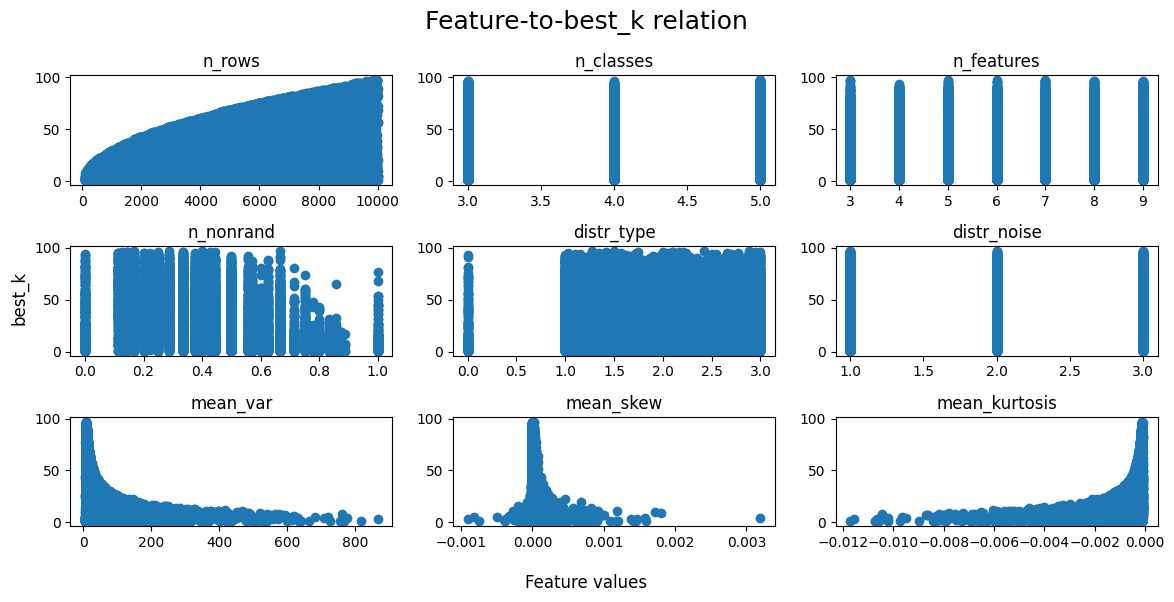

In [3]:
kg_test.show_features(dat) # show feature relations with 'best_k'

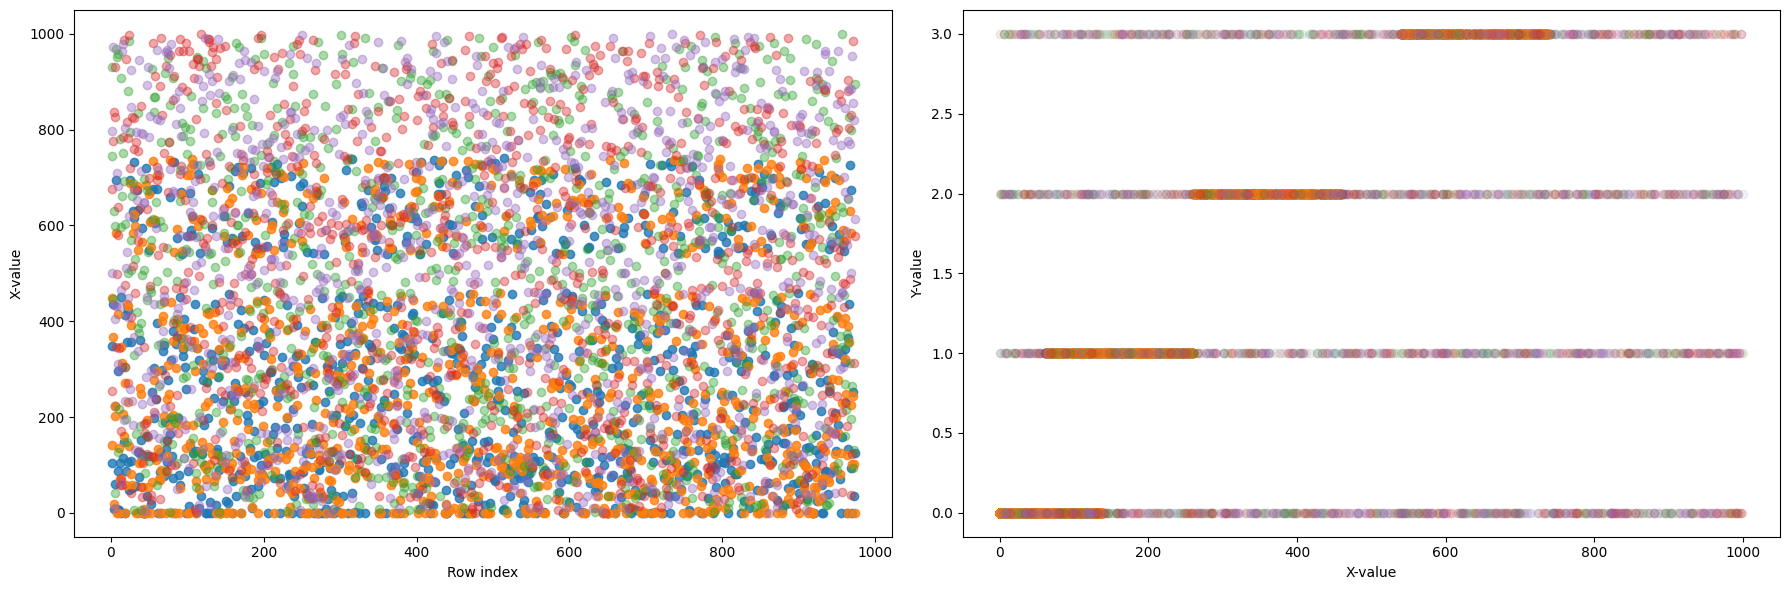

   y   x0   x1   x2   x3   x4
0  2  349  449  931  254  797
1  1  103  142  745  676  500
2  2  437  367  446  776  973
3  0    7   18  631  836  434
4  1   61  223  599  931  404


In [4]:
kg_test.params({'lim_row':[500,1000], 
                'distr_type':2, 
                'distr_noise':1})        # control generation (limited)
x, y, d_vi = kg_test.generate(view=True) # generate&plot a dataset
kg_test.show(x, y, columns=["y"]+[f"x{i+1}" for i in range(x.shape[1])])

In [5]:
vf = [f"{kg_test.head[i+1]}: {v}" for i, v 
      in enumerate(kg_test.get_features(x, y, d_vi))] # generation values
for txt in vf:
    print(txt)

n_rows: 973
n_classes: 4
n_features: 5
n_nonrand: 0.4
distr_type: 1.0478319950876027
distr_noise: 1
mean_var: 73.12749002274903
mean_skew: 0.00019475514272527416
mean_kurtosis: -0.0011582318837570138


## 3. Pipeline

### 3.1. Pre-process

Once the dataset has been obtained, we preprocess it in three steps:
1. One-hot encoding: We split categorical columns into multiple binary ones
2. Scaling: Values vary from e4 to e-4 or more. We scale them around e0 (and restore categoricals to 0/1 values)
3. Feature selection: We remove features that don't get at least a 0.2 correlation (categorical columns of a given feature are all kept)

A manual feature selection could also be done, if only by iterating models, so our pipeline allows for skipping step (3).

In [6]:
from kguesser import KG_model

kg_model = KG_model()
x, y = kg_model.preprocess(dat[:,1:], dat[:,0], verbose=False)
kg_model.show(x, y)

   best_k    n_rows  n_nonrand  distr_noise_1  distr_noise_2  distr_noise_3  \
0    25.0 -0.303060   0.208002            0.0            1.0            0.0   
1    19.0 -1.242738  -0.768364            0.0            1.0            0.0   
2    38.0 -1.014651  -0.349921            0.0            1.0            0.0   
3     1.0 -1.710125  -0.015168            0.0            0.0            1.0   
4     3.0 -0.182534   0.486963            1.0            0.0            0.0   

   mean_var  mean_kurtosis  
0 -0.249819       0.265517  
1  0.273149      -0.254489  
2 -0.021198      -0.017137  
3  5.906579      -5.224432  
4 -0.296446       0.262885  


### 3.2. Model

Since the `k` is a quantitative value, we chose to train a Linear Regression model. We test that model in two ways:
1. A 5-fold cross-validation on a training subset
2. An MSE/R2 score on the entire set

This means we split our dataset into a training and an evaluation dataset, use the training set for the cross-validation then train our model on that entire training set and get our MSE and R2 scores using the evaluation set. 

It is technically possible to retrieve more information on the linear regression model (coefficient, std, t-value, p-value). This is only partially implemented. [Note: As in I sometimes can't inverse the matrix, othertimes get divisions by zero and basically it's not worth the effort.]

In [7]:
kg_model.test_lm(x, y, preprocess=False); print("")

Model Performance:...                     
Cross-validation mean: 0.37 , std: 0.02
Mean Square Error: 377.80
R² Score: 0.39



Since the linear regression model is offering mitigated results, we can test another model. We will test a neuronal network. 

In [ ]:
kg_model.test_nn(x, y, params={'hidden_layer_sizes':[x.shape[1], 64, 32, 32]}, 
                 preprocess=False); print("")

## 4. Results

So far, our results suggest that the linear regression model is adapted to the task: a more powerful model doesn't seem to get better results. Likewise, while our features are limited (and noisy), `n_rows` and `mean_var` in particular seem significant enough. 

Therefore our efforts would focus on the simulations. For the purpose of testing the model, our generation is too complex. By generating more predictable data (and especially by isolating each feature) we should get a better idea of the model's behavior and, eventually, how to raise its accuracy.